In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=670be2c58c743241a8f367ba0897beb4a757db3e43e2e23578f98b21b65a532f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [7]:
!pip install pmdarima
import pyspark
import pyspark.sql as pyspark_sql
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [8]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [9]:
# Load datasets
df = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
df_pd = df.toPandas()

In [10]:
def get_data():
    location_df = pd.read_csv('Dataset/Preprocessed/cleaned_data.csv')

    # Convert the Current Date column to datetime
    location_df["Current Date"] = pd.to_datetime(location_df["Current Date"])

    # Sort the DataFrame by the date index
    location_df.sort_values(by="Current Date", inplace=True)

    # Set date as the index
    location_df.set_index("Current Date", inplace=True, drop=True)

    return location_df


In [19]:
def acf_adf(location_df, location_name):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    # Time Series Plot
    location_df.plot(ax=axes[0], y='HCHO reading', grid=True)
    axes[0].set_title(f"HCHO Reading over Time {location_name}")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("HCHO Reading")
    axes[0].legend(loc='lower right')

    # ACF Plot (Autocorrelation Function)
    plot_acf(location_df['HCHO reading'], lags=20, ax=axes[1])
    axes[1].set_title(f"Autocorrelation Function (ACF) for {location_name}")
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("ACF Value")

    # PACF Plot (Partial Autocorrelation Function)
    plot_pacf(location_df['HCHO reading'], lags=20, ax=axes[2])
    axes[2].set_title(f"Partial Autocorrelation Function (PACF) for {location_name}")
    axes[2].set_xlabel("Lags")
    axes[2].set_ylabel("PACF Value")

    plt.tight_layout()
    plt.show()
    print("\n")

    # Augmented Dickey-Fuller Test (ADF Test)
    adftest = adfuller(location_df['HCHO reading'], autolag='AIC', regression='ct')
    print(f"ADF Test Results {location_name}, \n")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("\n")
    if adftest[1] < 0.05:
      print("Conclusion: ")
      print("Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary ")
    else:
      print("Conclusion: ")
      print("Because P-value is greater than 0.05 , therefore the series is non_stationary ")
    print("\n")


In [20]:
# Load the data
df = get_data()

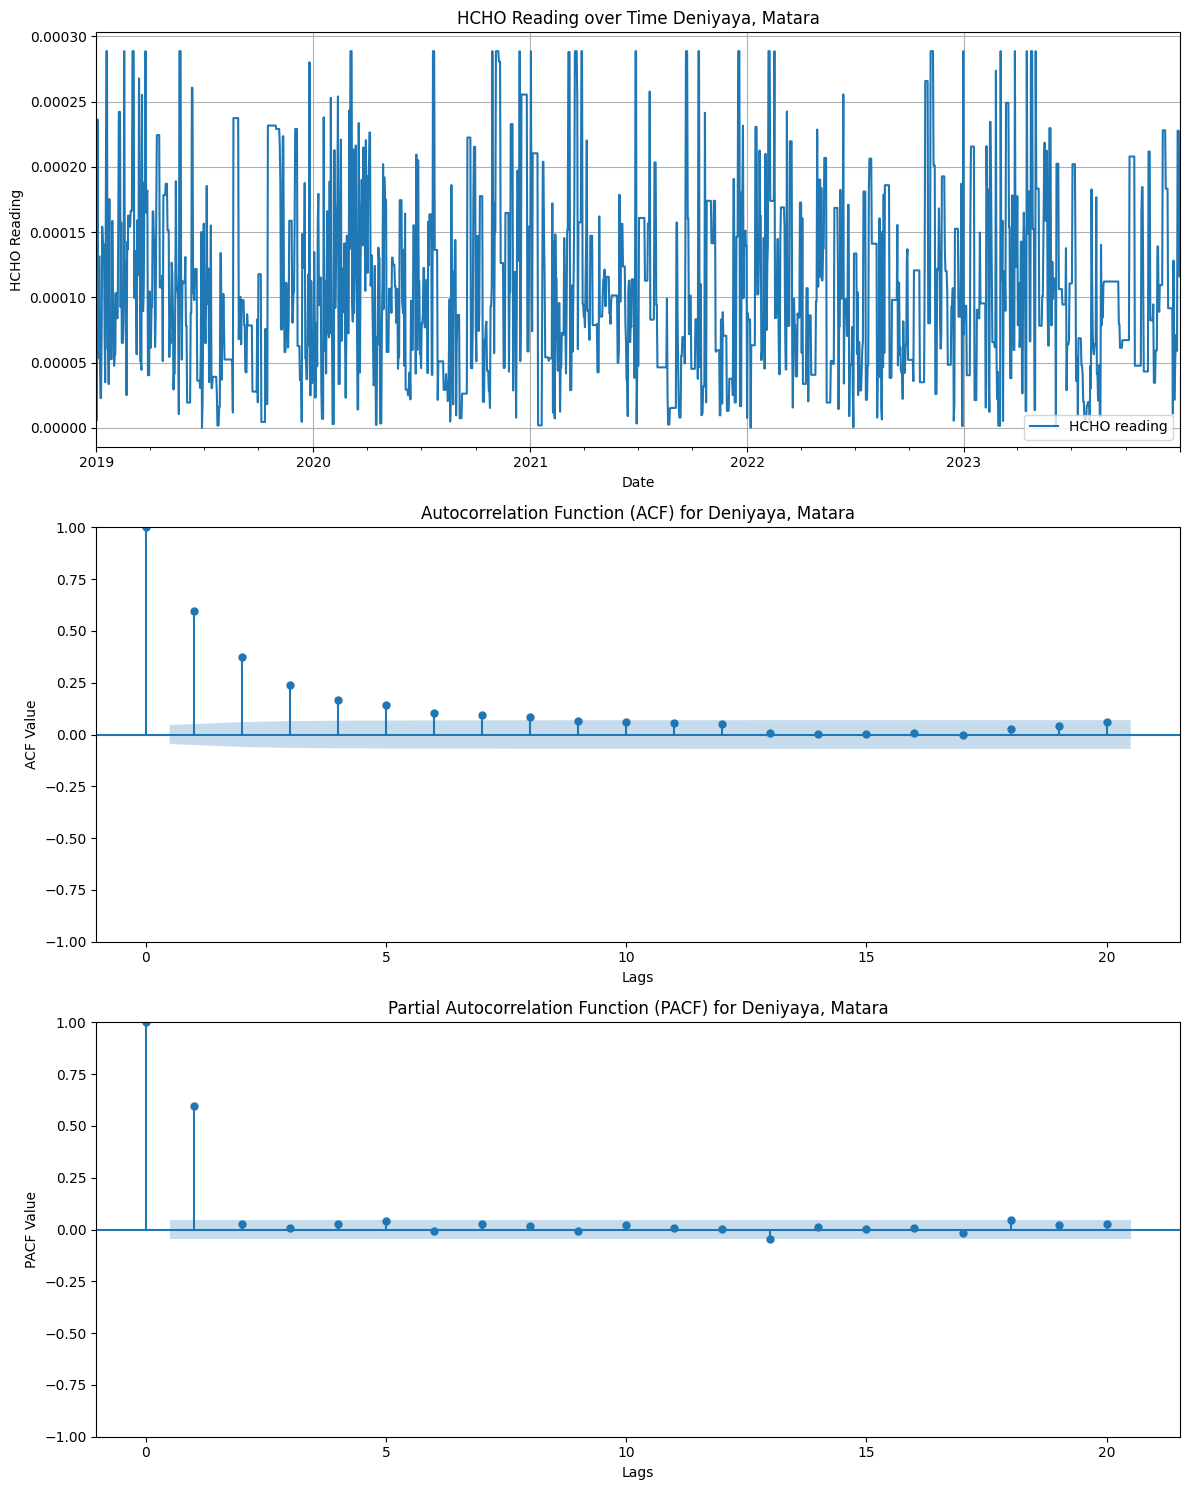



ADF Test Results Deniyaya, Matara, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -18.615577558696852
P-Value: 0.0
Number of lags: 1
Number of observations: 1824
Critical Values: {'1%': -3.9637418891719958, '5%': -3.4128997410008655, '10%': -3.1284687272976233}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [21]:
location_name = "Deniyaya, Matara"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

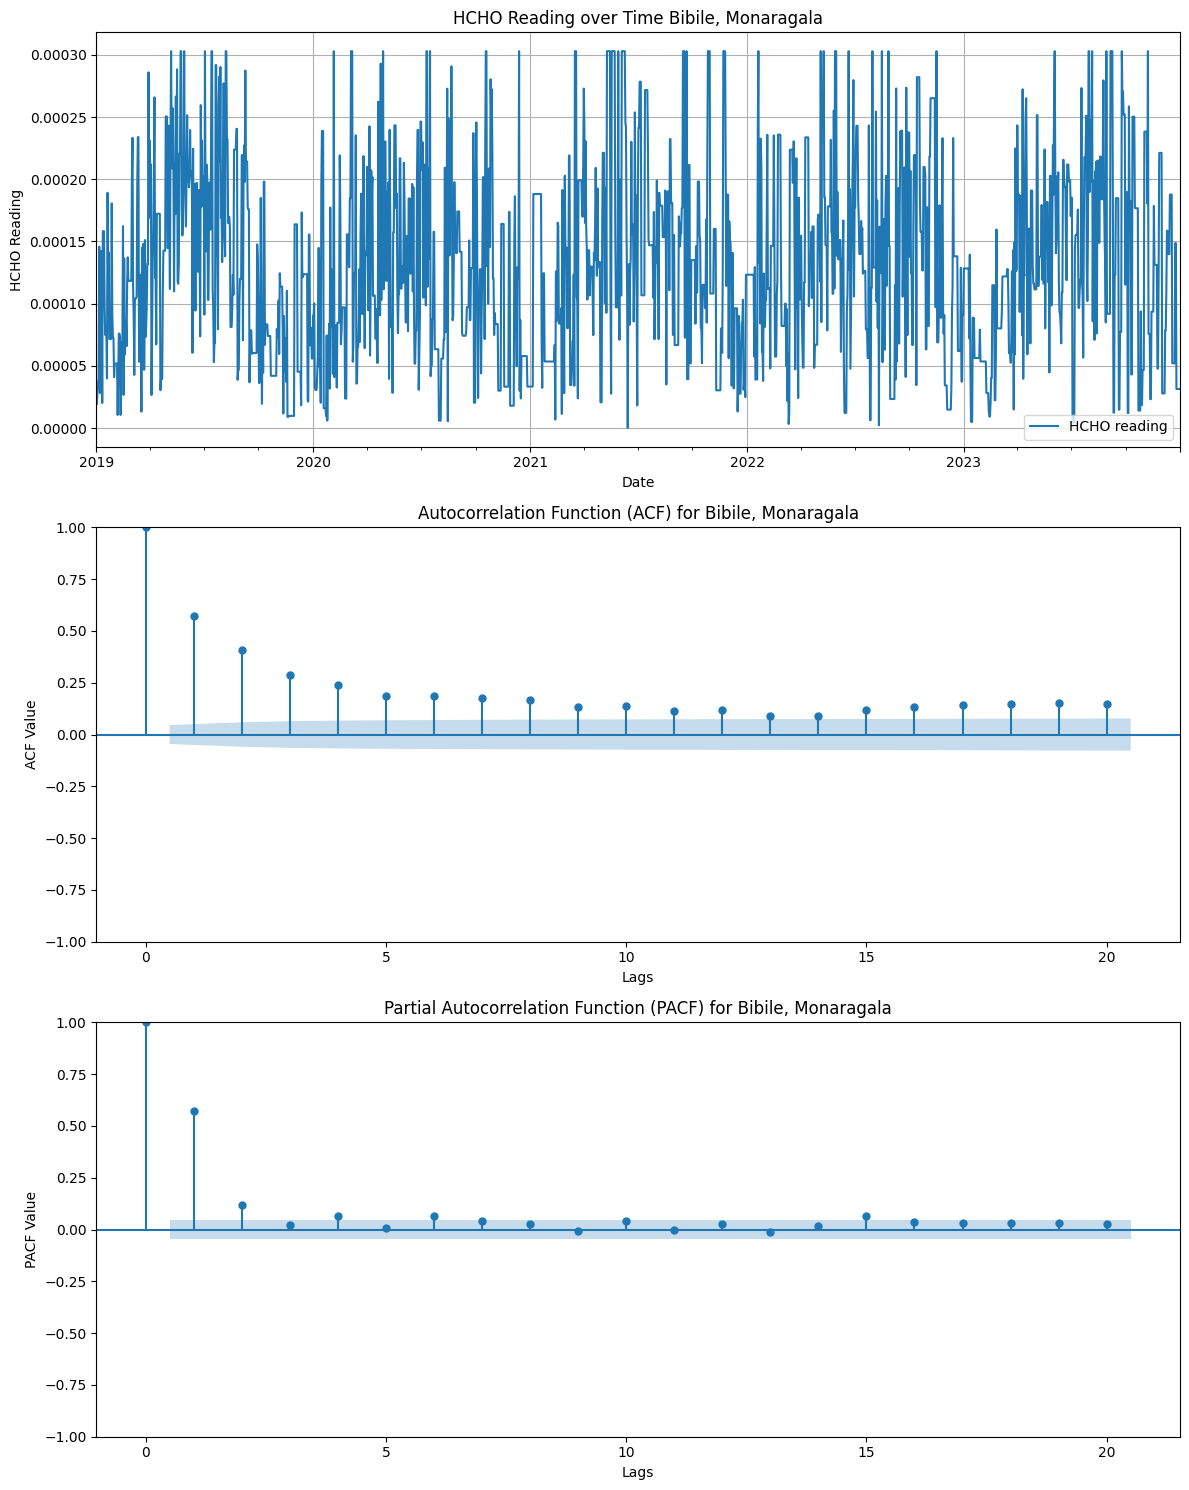



ADF Test Results Bibile, Monaragala, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -10.866678783037438
P-Value: 4.008964681240966e-17
Number of lags: 6
Number of observations: 1819
Critical Values: {'1%': -3.9637555793912167, '5%': -3.412906372335286, '10%': -3.1284726303149317}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [22]:
location_name = "Bibile, Monaragala"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

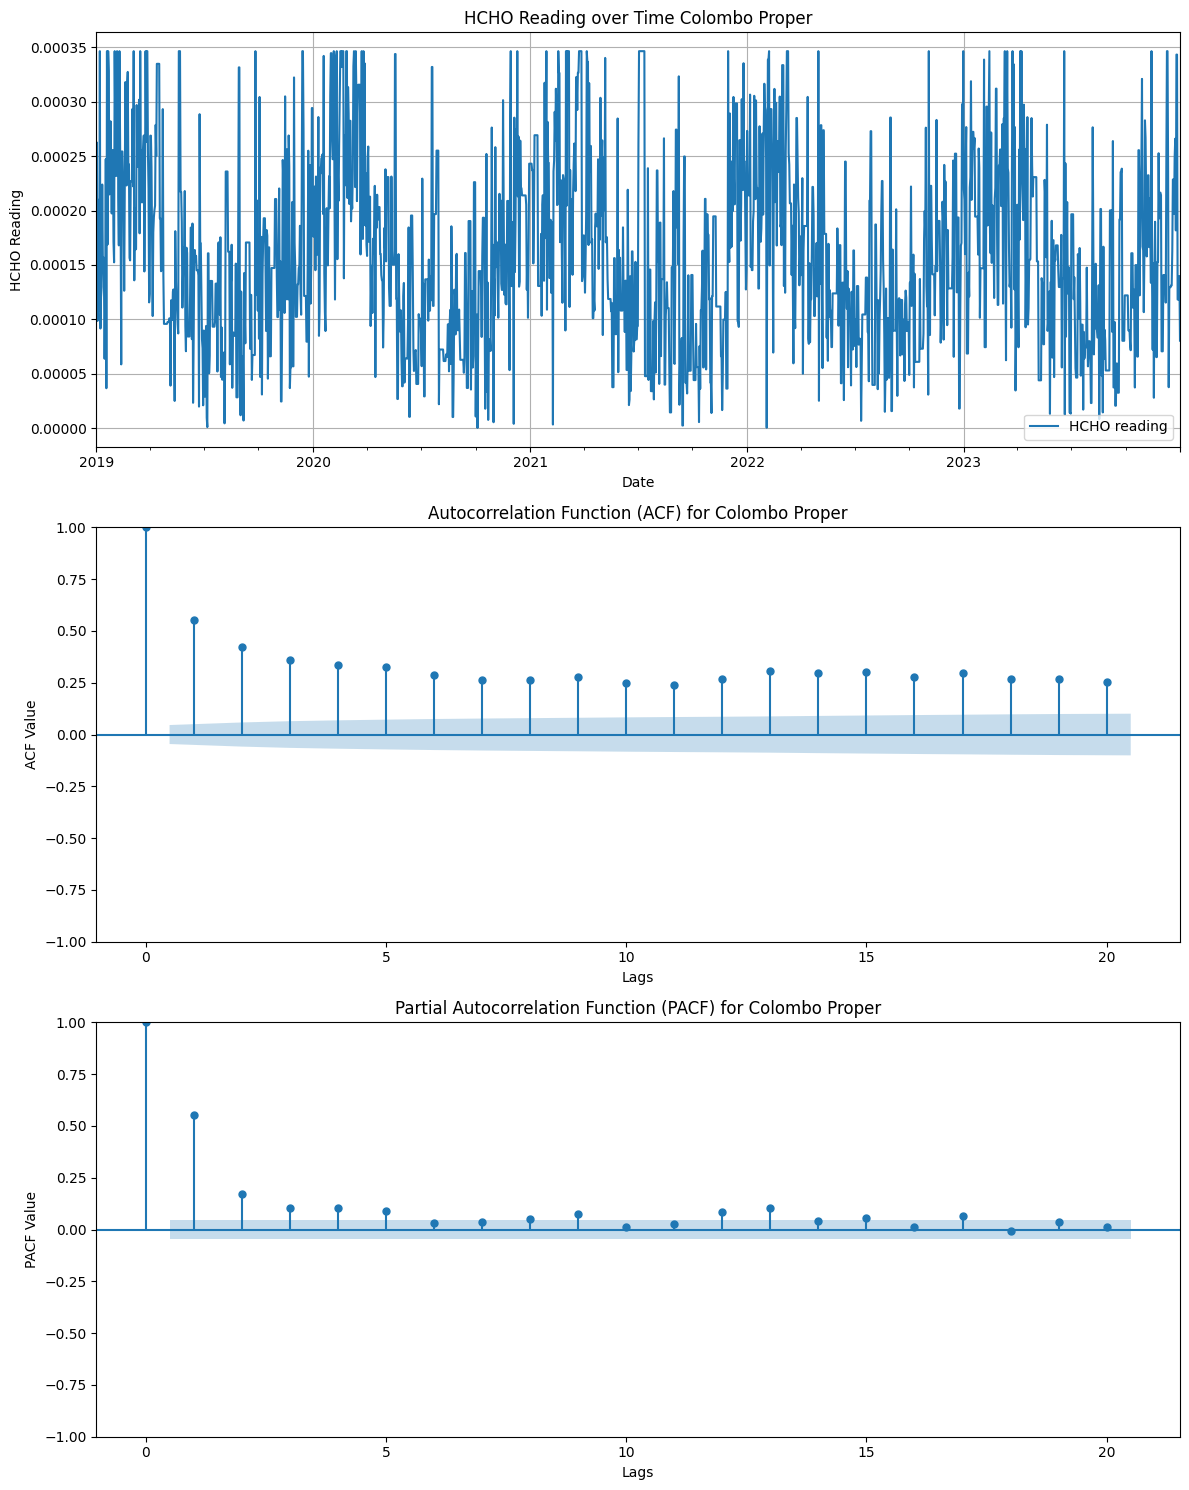



ADF Test Results Colombo Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.8166771448348635
P-Value: 0.00043789115270546236
Number of lags: 16
Number of observations: 1809
Critical Values: {'1%': -3.9637831872606, '5%': -3.412919745102375, '10%': -3.128480501130939}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [23]:
location_name = "Colombo Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

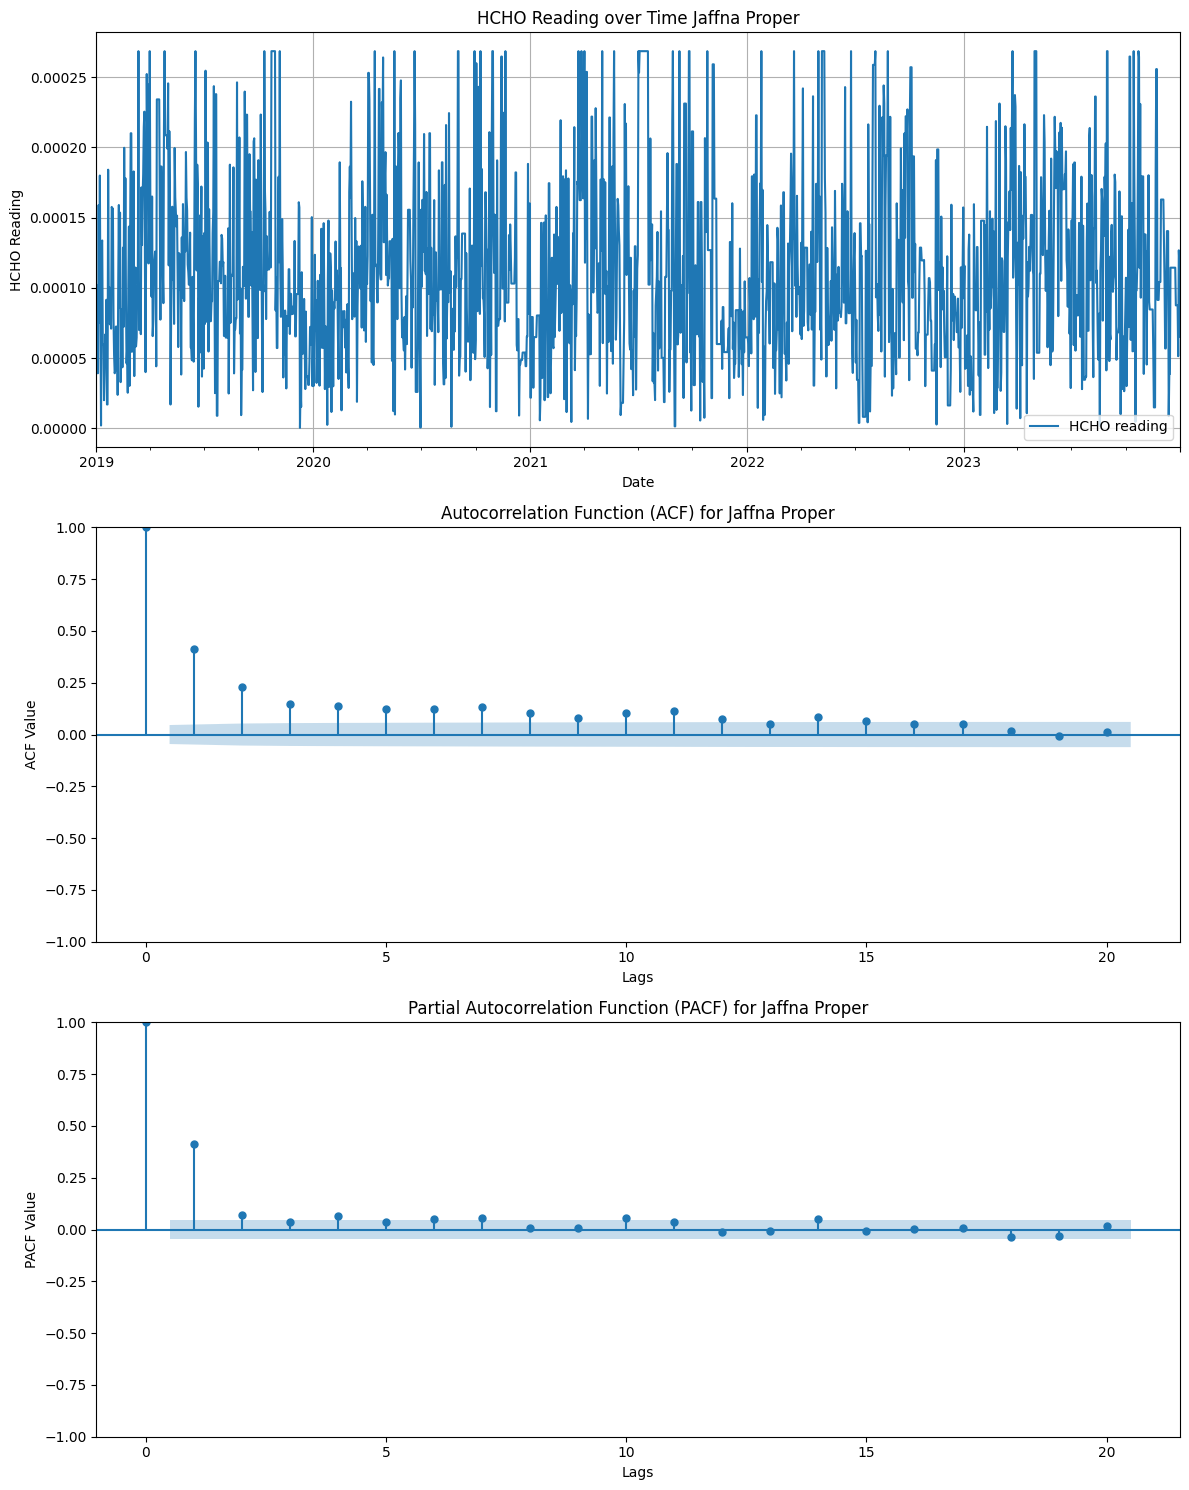



ADF Test Results Jaffna Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -11.646596568138975
P-Value: 1.495198542813012e-18
Number of lags: 6
Number of observations: 1819
Critical Values: {'1%': -3.9637555793912167, '5%': -3.412906372335286, '10%': -3.1284726303149317}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [24]:
location_name = "Jaffna Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

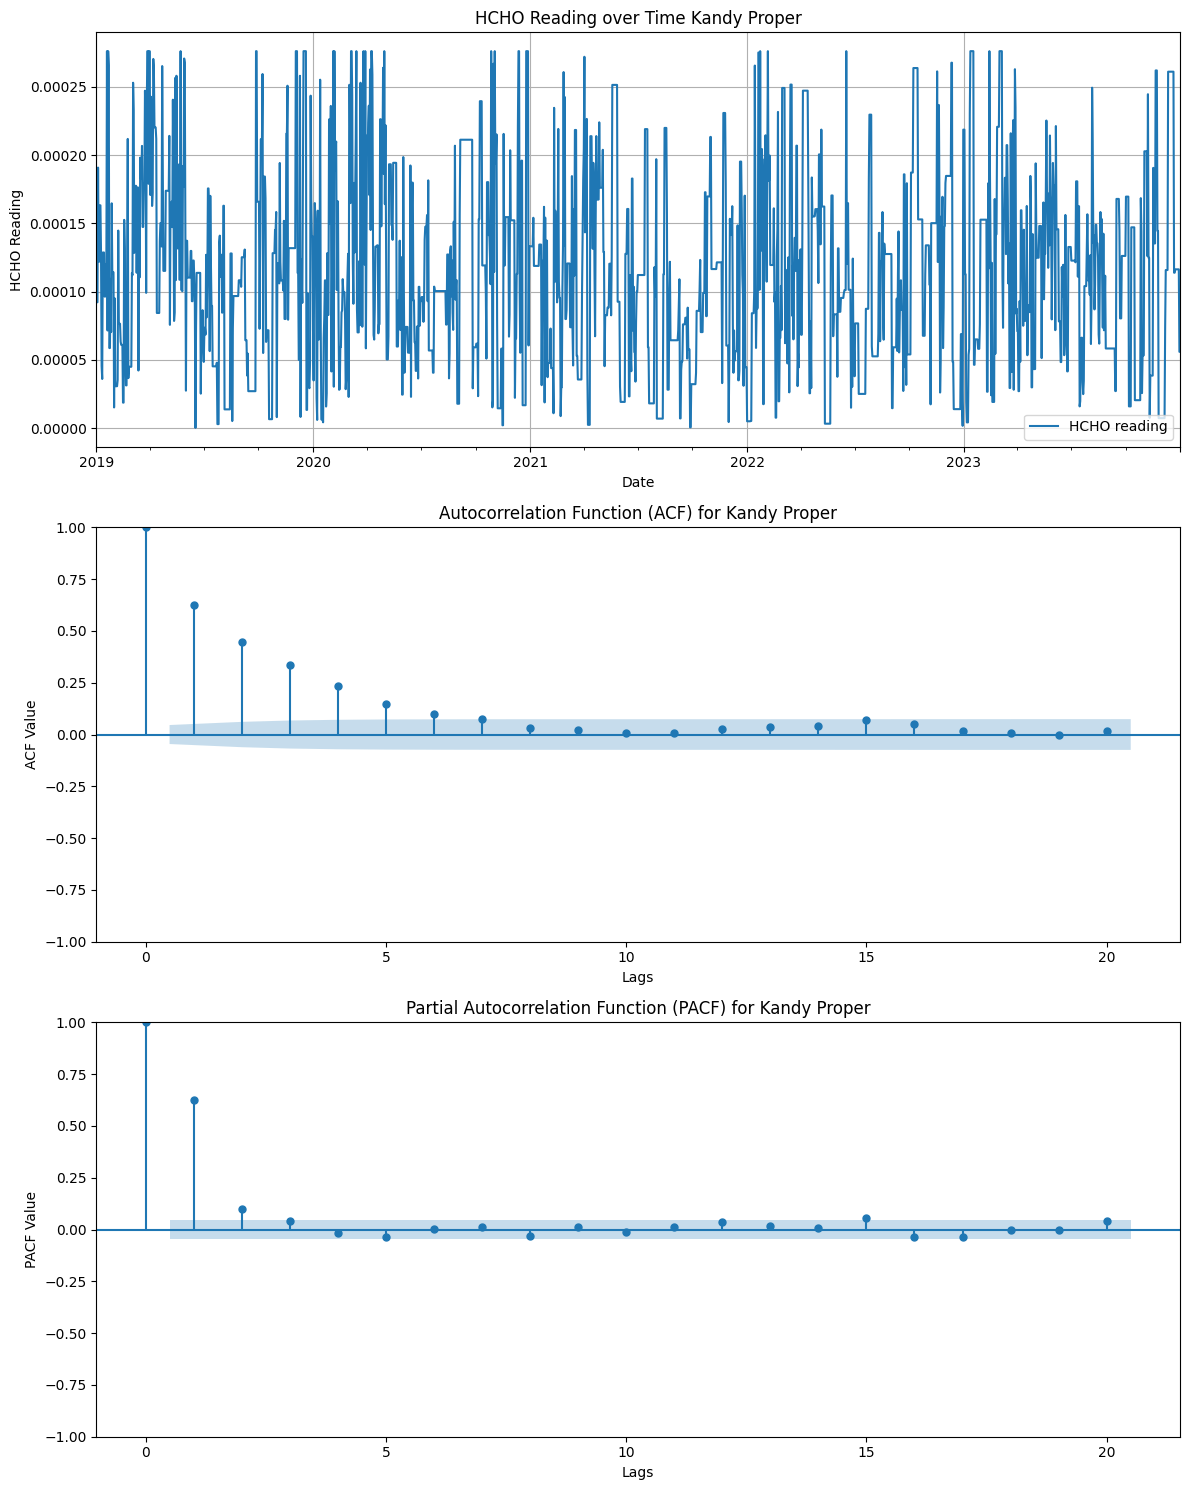



ADF Test Results Kandy Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -15.014879441705723
P-Value: 2.149578284093142e-22
Number of lags: 2
Number of observations: 1823
Critical Values: {'1%': -3.9637446211976712, '5%': -3.412901064354369, '10%': -3.128469506186859}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [25]:
location_name = "Kandy Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

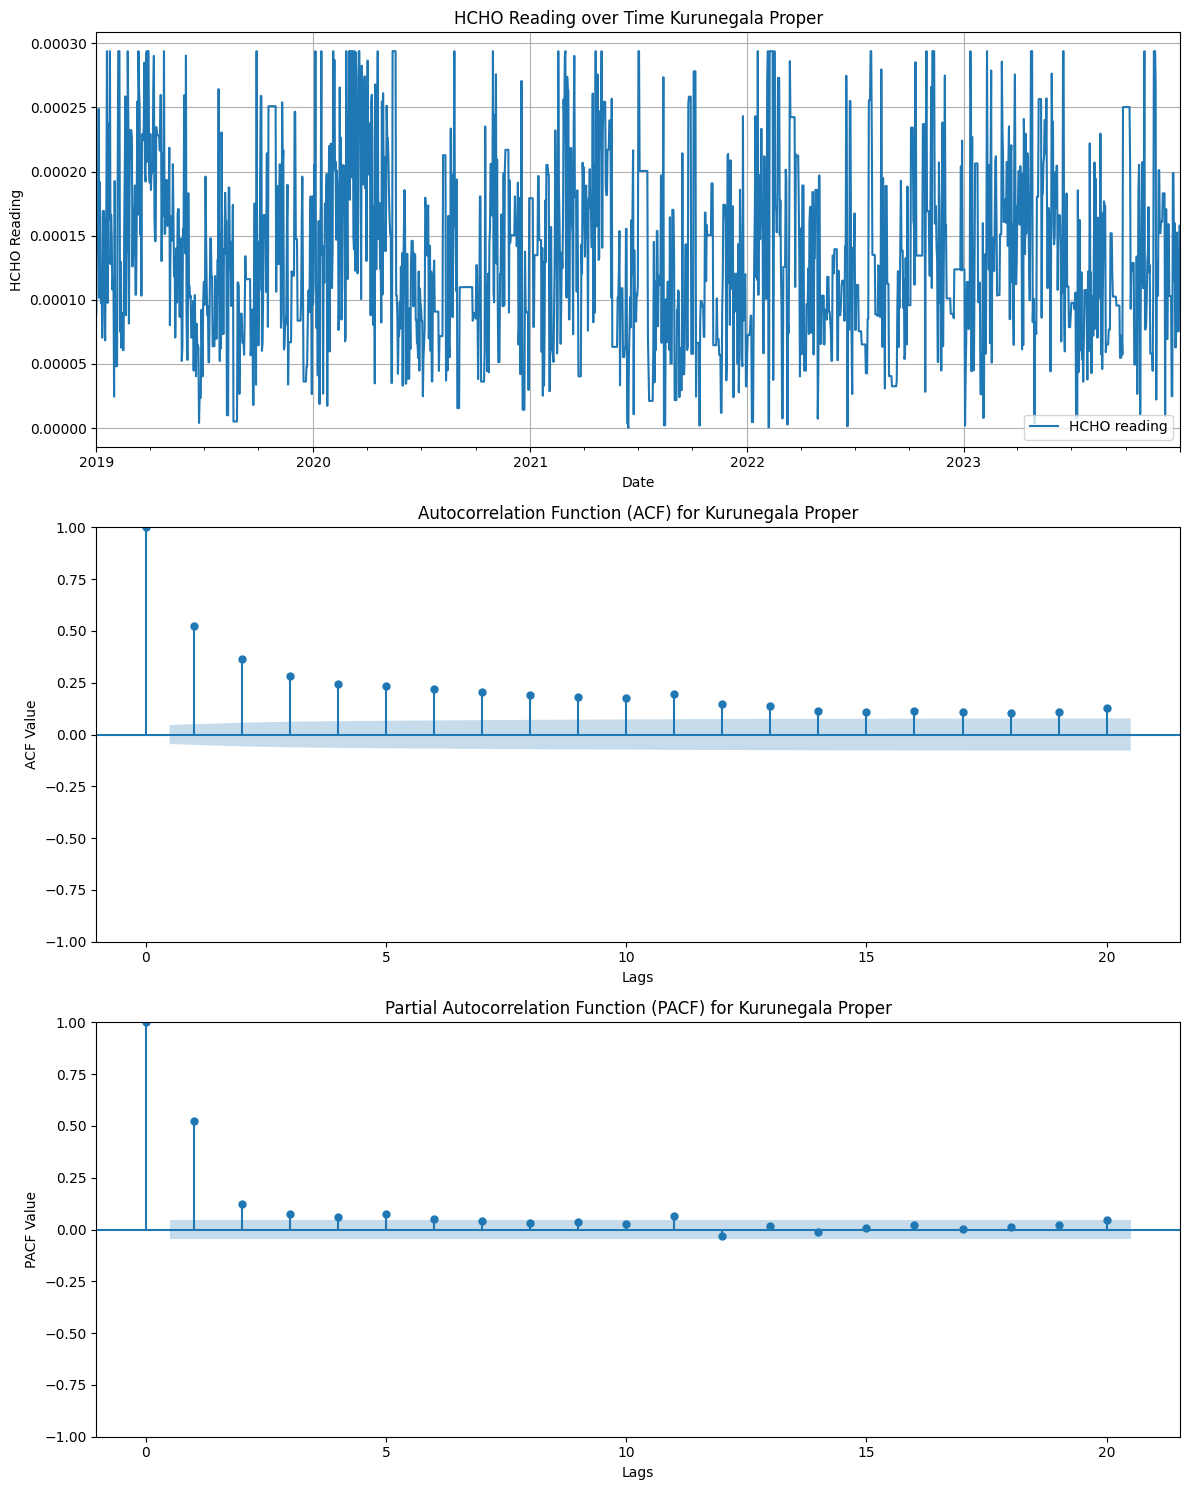



ADF Test Results Kurunegala Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -8.102084431181181
P-Value: 4.149698850713661e-11
Number of lags: 11
Number of observations: 1814
Critical Values: {'1%': -3.963769345211429, '5%': -3.412913040267851, '10%': -3.128476554866467}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [26]:
location_name = "Kurunegala Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

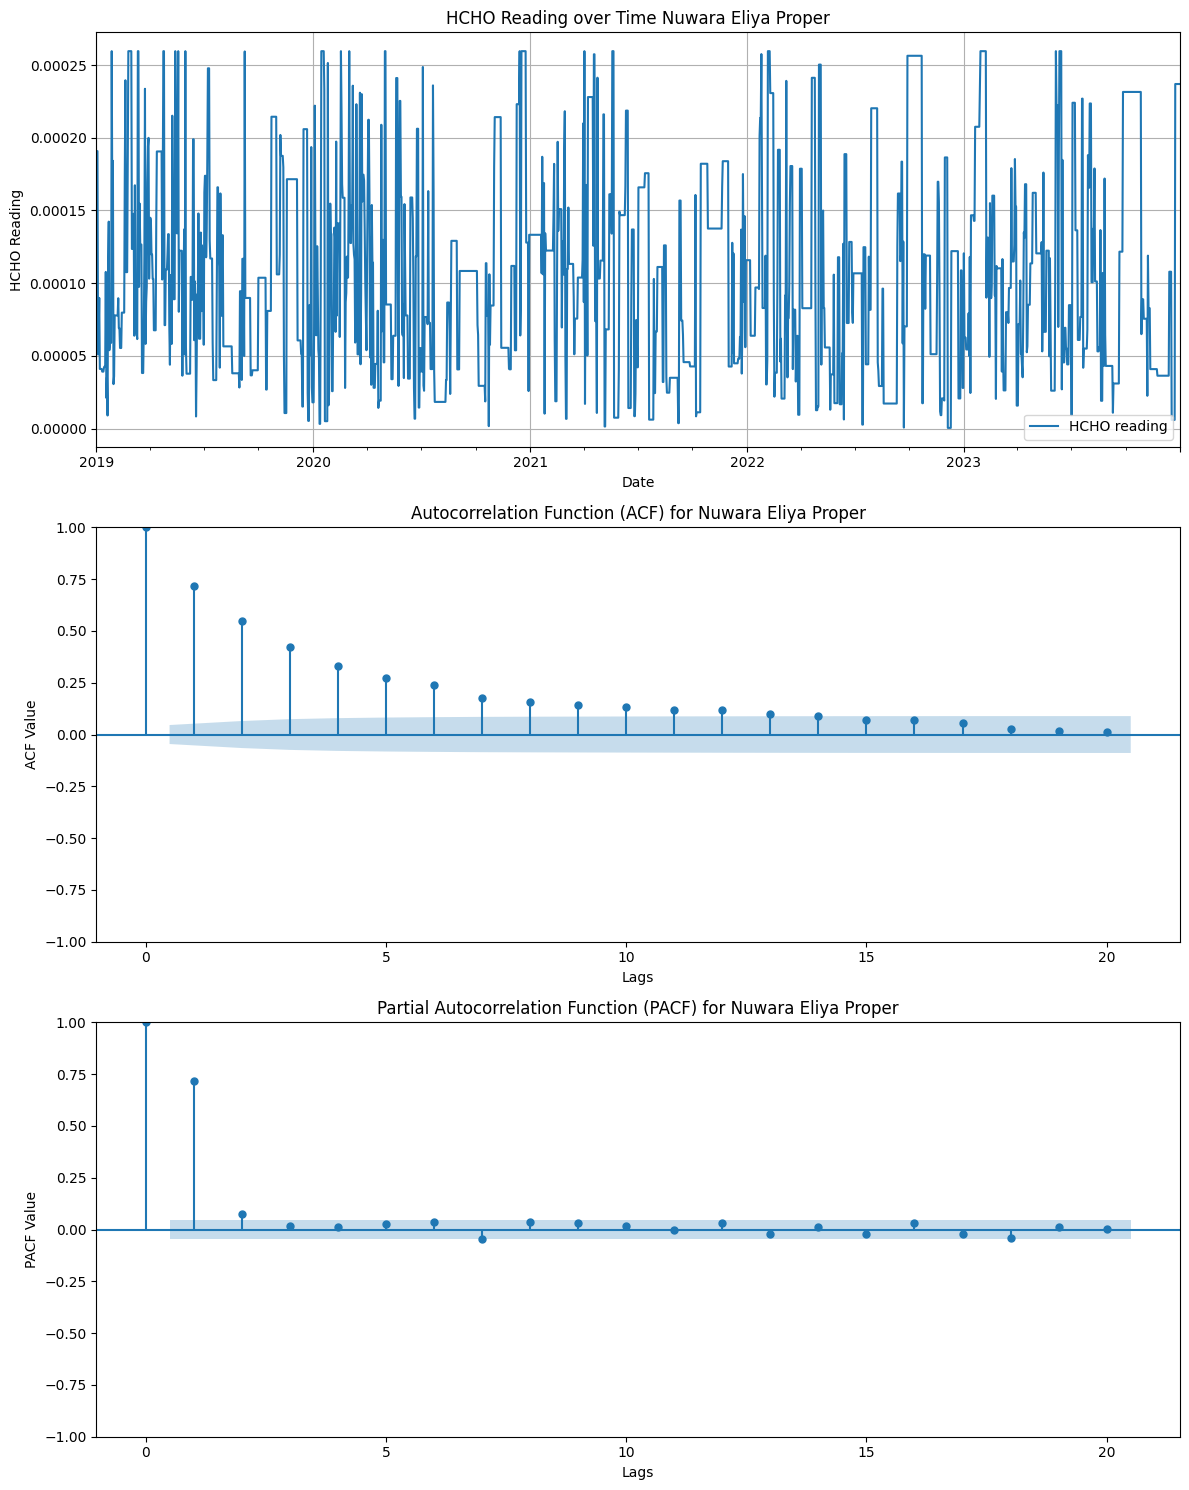



ADF Test Results Nuwara Eliya Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -14.907510775868595
P-Value: 2.4398992740046563e-22
Number of lags: 1
Number of observations: 1824
Critical Values: {'1%': -3.9637418891719958, '5%': -3.4128997410008655, '10%': -3.1284687272976233}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [27]:
location_name = "Nuwara Eliya Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)